## Load the tokenizer

In [18]:
import sys
sys.path.append('..')

In [19]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="../output/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

## Create the model

In [20]:
import torch
torch.manual_seed(3647)

In [ ]:
from transformer.model import GPTLanguageModel

block_size = 512
n_embd = 128
n_head = 8
n_layer = 1
dropout = 0.3
batch_size = 128
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

1.318922 M parameters


## Data preparation

### 1. Load the data

In [22]:
with open("../data/text_sequence.json", "r", encoding="utf-8") as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

70220

### 2. Split it into train and test

In [23]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)

# Build random non-overlapping start positions for block windows
num_positions = len(data) - block_size - 1
perm = torch.randperm(num_positions)

cut = int(0.9 * num_positions)
train_idx = perm[:cut]
val_idx = perm[cut:]


### 3. Data loader

In [24]:
from typing import Tuple

def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    idxs = train_idx if split == 'train' else val_idx
    # sample batch of starting positions
    starts = idxs[torch.randint(len(idxs), (batch_size,))]
    x = torch.stack([data[s:s+block_size] for s in starts])
    y = torch.stack([data[s+1:s+block_size+1] for s in starts])
    return x.to(device), y.to(device)


In [25]:
x, y = get_batch('train')
x.shape, y.shape

(torch.Size([128, 512]), torch.Size([128, 512]))

### 4. Training

In [26]:
from typing import Dict

eval_iters = 400


@torch.no_grad()
def estimate_loss() -> Dict:
    output = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        output[split] = losses.mean()
    model.train()
    return output

In [28]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [29]:
import torch; import torch._dynamo; torch._dynamo.config.suppress_errors = True

max_iters = 1000
eval_interval = 10
learning_rate = 5e-5
save_interval = 100

# ✅ Slightly stronger AdamW setup
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=0.1,
)

# ✅ Simple linear warmup (first 2% steps) then cosine decay
warmup_steps = max(1, int(0.02 * max_iters))
def lr_lambda(step):
    if step < warmup_steps:
        return float(step + 1) / float(warmup_steps)
    # cosine to zero
    progress = (step - warmup_steps) / max(1, (max_iters - warmup_steps))
    return 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda(step))

train_losses = []
val_losses = []

# ✅ Track and save best validation loss
best_val = float("inf")
best_ckpt_path = "../output/pre_training/run_1/best.pth"


for iteration in range(max_iters):
    # Evaluate
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train'].item() if hasattr(losses['train'], 'item') else float(losses['train'])
        val_loss = losses['val'].item() if hasattr(losses['val'], 'item') else float(losses['val'])
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step {iteration}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # ✅ Save best model so far
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_ckpt_path)

    # Train step
    x_batch, y_batch = get_batch('train')
    logits, loss = model(x_batch, y_batch)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # ✅ gentle gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()  # ✅ update LR each step

    # Optional periodic full checkpoint (kept from your code)
    if iteration % save_interval == 0:
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../output/pre_training/run_1/checkpoint_{iteration}.pth"
        )


step 0: train loss 8.3481, val loss 8.3482
step 10: train loss 8.3337, val loss 8.3337
step 20: train loss 8.2940, val loss 8.2939
step 30: train loss 8.2432, val loss 8.2432
step 40: train loss 8.1923, val loss 8.1923
step 50: train loss 8.1425, val loss 8.1424
step 60: train loss 8.0946, val loss 8.0944
step 70: train loss 8.0498, val loss 8.0497
step 80: train loss 8.0081, val loss 8.0081
step 90: train loss 7.9698, val loss 7.9696
step 100: train loss 7.9338, val loss 7.9335
step 110: train loss 7.9000, val loss 7.8998
step 120: train loss 7.8686, val loss 7.8684
step 130: train loss 7.8395, val loss 7.8389
step 140: train loss 7.8120, val loss 7.8114
step 150: train loss 7.7863, val loss 7.7860
step 160: train loss 7.7621, val loss 7.7622
step 170: train loss 7.7397, val loss 7.7390
step 180: train loss 7.7176, val loss 7.7172
step 190: train loss 7.6963, val loss 7.6960
step 200: train loss 7.6759, val loss 7.6757
step 210: train loss 7.6561, val loss 7.6559
step 220: train loss 

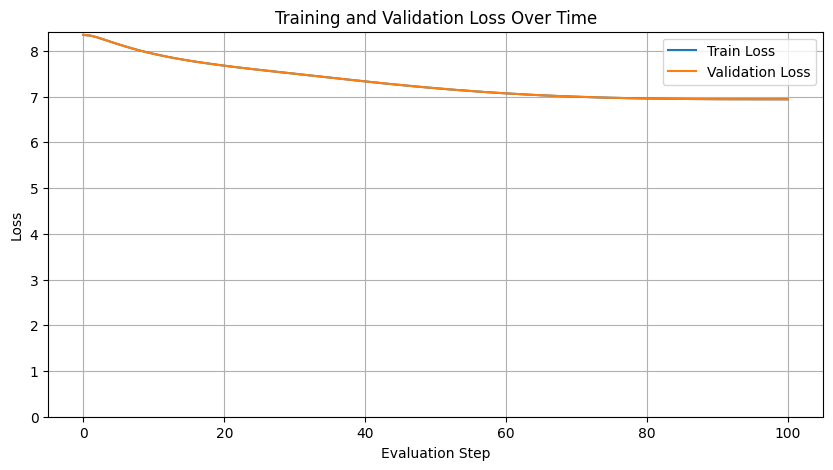

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylim(0)
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [35]:
# A better, more specific prompt + safer decoding settings
prompt = (
    "Schreibe in dritter Person Präteritum, kurze Sätze.\n"
    "Figur: Aaliyah, Prinzessin im Exil.\n"
    "Szene: Nächtlicher Innenhof. Kara verlangt die Wahrheit.\n"
    "Antwort: "
)

input_tokens = tokenizer.encode(prompt)
input_tokens = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens, max_new_tokens=150)
print(tokenizer.decode(output[0].tolist()))


Schreibe in dritter Person Präteritum, kurze Sätze.
Figur: Aaliyah, Prinzessin im Exil.
Szene: Nächtlicher Innenhof. Kara verlangt die Wahrheit.
Antwort: seheit Jeliowarhast Ande istLEs ehvort. so viel euch , dass sicherKönig blickte von traues nicht an en wollAranien ihrem LüHerz nie ache Dich etwasA, dass ihr mit dem shTunst, ist ein wieder Troallhat aber einem �z Geschichbin die Tennen  damit ste fliefTeilen. Und egalte sich  da sie waronenß beobachspielein soll terer eine hätWorte nichtt und bezweifet, was Dir BoWas was ich wenn du.\" sie  direkinteressierächte. \"o! Ich ssteigGesicht en und vor wo sie ge mit dem nochmal erin hoeinfach GrossOnk, aber ich täuäschla die KelerzGedanken tun . Du von dem hatte erne das Eist das – uns etzt die Vielleichs. \". \"Du zeiArbogast sich in Warbei gesehglauben s offensproch dirauf sichtlich war so wenn n meinst er mein 
